# Load and save **jinns** models

In this notebook we demonstrate how you can load and save **jinns** models that you have trained and want to reuse in another context.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

Import our package

In [2]:
import jinns

2024-09-27 16:10:02.165815: W external/xla/xla/service/gpu/nvptx_compiler.cc:893] The NVIDIA driver's CUDA version is 12.2 which is older than the PTX compiler version 12.3.107. Because the driver is older than the PTX compiler version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


Import other dependencies

In [3]:
import jax
from jax import random, vmap
import jax.numpy as jnp
import equinox as eqx
from functools import partial
import matplotlib.pyplot as plt

key = random.PRNGKey(2)

Create the neural network architecture for the PINN and the dictionary of parameters

In [4]:
eqx_list = [
    [eqx.nn.Linear, 2, 128],
    [jax.nn.tanh],
    [eqx.nn.Linear, 128, 128],
    [jax.nn.tanh],
    [eqx.nn.Linear, 128, 128],
    [jax.nn.tanh],
    [eqx.nn.Linear, 128, 1]
]
key, subkey = random.split(key)
u_pinn = jinns.utils.create_PINN(subkey, eqx_list, "nonstatio_PDE", 1)

In [8]:
params_pinn = jinns.parameters.Params(
    nn_params=u_pinn.init_params(),
    eq_params={}
)

In [9]:
nx = 500
val_xdata = jnp.linspace(0, 1, nx)
ntime = 500
val_times = jnp.linspace(0, 1, ntime)

Plot the solution

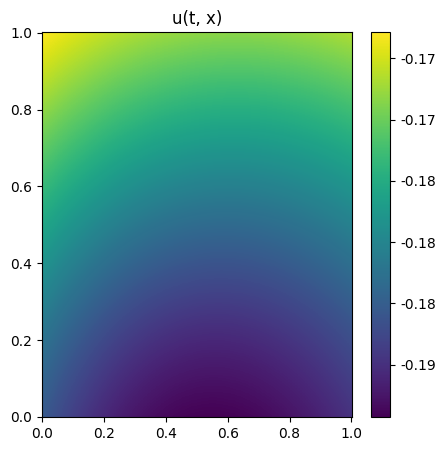

In [11]:
u_est_pinn = lambda t, x:u_pinn(t, x, params_pinn.nn_params)
# same subkey
jinns.plot.plot1d_image(u_est_pinn, xdata=val_xdata, times=val_times, cmap="viridis", colorbar=True, figsize=(5, 5), title="u(t, x)")

## Train the model and do stuff
[...]

## Save the model

This step uses the new functions `jinns.utils.save_pinn` and `jinns.utils.load_pinn` introduced in **jinns** v0.8.1.

The save function takes 4 arguments as input:

- A filename prefix
- The PINN model
- The PINN's Params or ParamsDict object
- A dictionary which lists the arguments that were used to create the PINN model

The save function will then save 3 files that you need store and that will be used for reloading the model. You can share these files to disseminate your model:

- A file `{filename}-module.eqx`, this store the PINN model which is an `equinox` module (stores all the attributes of the module except the parameters). (In the case of a ParamsDict, this would be `{filename}-module{key}.eqx` with `key` from the dictionary `ParamsDict.nn_params`).
- A file `{filename}-eq_params.pkl`, this stores the dictionary of parameters of the equation
- A file `{filename}-arguments.pkl`, this stores the dictionary of arguments used to create the equinox module

For an detailed and technical description see the `_save_load.py` file in the `jinns.utils` module.

In [12]:
from jinns.utils import save_pinn, load_pinn

In [13]:
filename = "./test"
kwargs_creation = {
    "key": subkey,
    "eqx_list": eqx_list,
    "eq_type":"nonstatio_PDE",
    "dim_x":1
}
save_pinn(filename, u_pinn, params_pinn, kwargs_creation)

## Reload model

The `jinns.utils.load_pinn` function returns a pair: the PINN module and the parameters that were saved. You just need to pass a filename prefix and the function will look for the `{filename}-module.eqx`, `{filename}-eq_params.pkl` and `{filename}-arguments.pkl` files. You also need to pass the `type_` arguments which specifies which kind of PINN model you want to load (either a vanilla PINN, a SPINN or an HyperPINN).

In [14]:
u_pinn_reloaded, params_pinn_reloaded = load_pinn(filename, type_="pinn")

Check that we reload the exepted model:

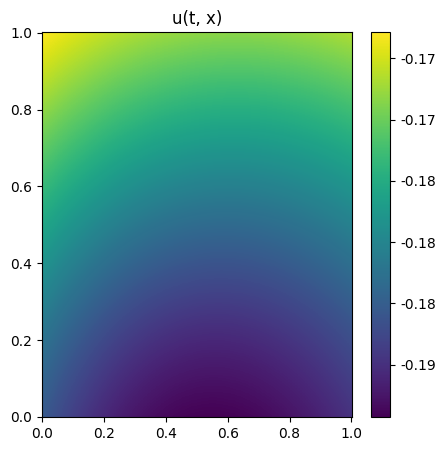

In [15]:
u_est_pinn_reloaded = lambda t, x:u_pinn_reloaded(t, x, params_pinn_reloaded.nn_params)
# same subkey
jinns.plot.plot1d_image(u_est_pinn_reloaded, xdata=val_xdata, times=val_times, cmap="viridis", colorbar=True, figsize=(5, 5), title="u(t, x)")